# Wind Downscaling


In [1]:
import os
from datetime import date, datetime
from pathlib import Path

from dotenv import load_dotenv

from data.data_generator import BatchGenerator, NaiveDecoder, LocalFileProvider, S3FileProvider
from gan import train, metrics
load_dotenv()
import numpy as np
import tensorflow as tf
import tensorflow.keras.callbacks as cb
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
import pandas as pd

Num GPUs Available: 0


## Set configuration

In [2]:
DATA_ROOT = Path('./data')
ERA5_DATA_FOLDER = DATA_ROOT / 'ERA5'
COSMO1_DATA_FOLDER = DATA_ROOT / 'COSMO1'
DEM_DATA_FILE = DATA_ROOT / 'dem/Switzerland-90m-DEM.tif'
PROCESSED_DATA_FOLDER = DATA_ROOT / 'img_prediction_files'
DATA_ROOT.mkdir(parents=True, exist_ok=True)
ERA5_DATA_FOLDER.mkdir(exist_ok=True)
COSMO1_DATA_FOLDER.mkdir(exist_ok=True)
DEM_DATA_FILE.parent.mkdir(exist_ok=True)
PROCESSED_DATA_FOLDER.mkdir(exist_ok=True)
cosmoblurred = True
run_id=datetime.today().strftime('%Y%m%d_%H%M')
data_provider = 'local'

In [3]:
# Start and end date for the data - should be in the 2016-2020 range
START_DATE = date(2017,1,1)
END_DATE = date(2017,3,31)
NUM_DAYS = (END_DATE-START_DATE).days + 1
# Number of consecutive images to form a sequence
SEQUENCE_LENGTH = 3
# Size of the high resolution image to be produced
IMG_SIZE = 64
# Number of sequences per batch
BATCH_SIZE = 8
# Number of noise channels to add to the image
NOISE_CHANNELS = 1

In [4]:
TOPO_PREDICTORS = ['tpi_500', 'slope', 'aspect']
HOMEMADE_PREDICTORS = ['e_plus', 'e_minus', 'w_speed', 'w_angle']
ERA5_PREDICTORS_SURFACE = ['u10', 'v10', 'blh', 'fsr', 'sp', 'sshf']
ERA5_PREDICTORS_Z500 = ['z']
if cosmoblurred:
    ALL_INPUTS = ['U_10M', 'V_10M'] + HOMEMADE_PREDICTORS + TOPO_PREDICTORS
    input_pattern = 'x_cosmo_{date}.nc'
    run_id = f'{run_id}_cosmo_blurred'
else:
    ALL_INPUTS = ERA5_PREDICTORS_Z500 + ERA5_PREDICTORS_SURFACE + TOPO_PREDICTORS + HOMEMADE_PREDICTORS
    input_pattern = 'x_{date}.nc'
ALL_INPUTS = ['U_10M', 'V_10M']
ALL_OUTPUTS = ['U_10M', 'V_10M']
BATCH_WORKERS = os.cpu_count()
if data_provider == 'local':
    input_provider = LocalFileProvider(PROCESSED_DATA_FOLDER, input_pattern)
    output_provider = LocalFileProvider(PROCESSED_DATA_FOLDER, 'y_{date}.nc')
elif data_provider == 's3':
    input_provider = S3FileProvider('wind-downscaling', 'img_prediction_files', pattern=input_pattern)
    output_provider = S3FileProvider('wind-downscaling', 'img_prediction_files', pattern='y_{date}.nc')
else:
    raise ValueError(f'Wrong value for data provider {data_provider}: please choose between s3 and local')
AVAIL_DATES = [pd.to_datetime(v) for v in
               set(input_provider.available_dates).intersection(output_provider.available_dates)]
START_DATE = min(AVAIL_DATES)
END_DATE = max(AVAIL_DATES)
batch_gen = BatchGenerator(input_provider, output_provider,
                                    decoder=NaiveDecoder(normalize=True),
                                    sequence_length=SEQUENCE_LENGTH,
                                    patch_length_pixel=IMG_SIZE, batch_size=BATCH_SIZE,
                                    input_variables=ALL_INPUTS,
                                    output_variables=ALL_OUTPUTS,
                                    start_date=START_DATE, end_date=END_DATE,
                                    num_workers=BATCH_WORKERS)
INPUT_CHANNELS = len(ALL_INPUTS)
OUT_CHANNELS = len(ALL_OUTPUTS)

In [5]:
inputs = []
outputs = []
with batch_gen as batch:
    for b in range(NUM_DAYS):
        print(f'Creating batch {b+1}/{NUM_DAYS}')
        x, y = next(batch)
        inputs.append(x)
        outputs.append(y)
inputs = np.concatenate(inputs, axis=0)
outputs = np.concatenate(outputs, axis=0)
print(f"Inputs: {inputs.shape}")
print(f"Outputs: {outputs.shape}")

Creating batch 1/90
Creating batch 2/90
Creating batch 3/90
Creating batch 4/90
Creating batch 5/90
Creating batch 6/90
Creating batch 7/90
Creating batch 8/90
Creating batch 9/90
Creating batch 10/90
Creating batch 11/90
Creating batch 12/90
Creating batch 13/90
Creating batch 14/90
Creating batch 15/90
Creating batch 16/90
Creating batch 17/90
Creating batch 18/90
Creating batch 19/90
Creating batch 20/90
Creating batch 21/90
Creating batch 22/90
Creating batch 23/90
Creating batch 24/90
Creating batch 25/90
Creating batch 26/90
Creating batch 27/90
Creating batch 28/90
Creating batch 29/90
Creating batch 30/90
Creating batch 31/90
Creating batch 32/90
Creating batch 33/90
Creating batch 34/90
Creating batch 35/90
Creating batch 36/90
Creating batch 37/90
Creating batch 38/90
Creating batch 39/90
Creating batch 40/90
Creating batch 41/90
Creating batch 42/90
Creating batch 43/90
Creating batch 44/90
Creating batch 45/90
Creating batch 46/90
Creating batch 47/90
Creating batch 48/90
C

In [6]:
INPUT_CHANNELS = len(ALL_INPUTS)
OUT_CHANNELS = len(ALL_OUTPUTS)

In [7]:
from gan.models import make_generator, make_discriminator
from gan.ganbase import  GAN
from data.data_generator import FlexibleNoiseGenerator

generator = make_generator(image_size=IMG_SIZE, in_channels=INPUT_CHANNELS,
                           noise_channels=NOISE_CHANNELS, out_channels=OUT_CHANNELS,
                           n_timesteps=SEQUENCE_LENGTH)
print(f"Generator: {generator.count_params():,} weights")

discriminator = make_discriminator(low_res_size=IMG_SIZE, high_res_size=IMG_SIZE, low_res_channels=INPUT_CHANNELS,
                                   high_res_channels=OUT_CHANNELS, n_timesteps=SEQUENCE_LENGTH)
print(f"Discriminator: {discriminator.count_params():,} weights")

noise_shape = (BATCH_SIZE, SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, NOISE_CHANNELS)
gan = GAN(generator, discriminator, noise_generator=FlexibleNoiseGenerator(noise_shape, std=0.01))

print(f"Total: {gan.generator.count_params() + gan.discriminator.count_params():,} weights")

Generator: 1,385,106 weights
Discriminator: 2,123,081 weights
Total: 3,508,187 weights


In [8]:
gan.compile(generator_optimizer=train.generator_optimizer(),
            generator_metrics= [tf.keras.metrics.RootMeanSquaredError(), metrics.LogSpectralDistance(),
                                metrics.WeightedRMSEForExtremes(), metrics.WindSpeedWeightedRMSE(),
                                metrics.SpatialKS(), metrics.AngularCosineDistance()],
            discriminator_optimizer=train.discriminator_optimizer(),
                discriminator_loss=train.discriminator_loss,
           metrics = [metrics.discriminator_score_fake(), metrics.discriminator_score_real()])

In [9]:
checkpoint_path_weights = Path('./checkpoints/gan') / run_id / 'weights-{epoch:02d}.ckpt'
checkpoint_path_weights.parent.mkdir(exist_ok=True, parents=True)
log_path = Path('./logs/gan') / run_id
if log_path.exists():
    log_path_str = str(log_path)
    !rm -rf {log_path_str}

In [10]:
%load_ext tensorboard
%tensorboard --logdir=$log_path

In [11]:
import matplotlib.pyplot as plt
def show(images, dims=1, legends=None):
    fig, axes = plt.subplots(ncols= len(images), figsize=(10, 10))
    for ax, im in zip(axes, images):
        for i in range(dims):
            label = legends[i] if legends is not None else ''
            ax.imshow(im[0, :, :, i], cmap='jet')
            ax.set_title(label)
            ax.axis('off')
    plt.show()
    return fig

In [12]:
class ShowCallback(tf.keras.callbacks.Callback):
    def __init__(self, dims):
        self.dims = dims
        
    def on_epoch_begin(self, epoch, logs):
        noise = FlexibleNoiseGenerator(noise_shape)
        show(self.model.generator([inputs[:self.dims], noise(self.dims)]))

In [13]:
callbacks = [
        cb.TensorBoard(log_path, write_images=True, update_freq='batch'),
        cb.ProgbarLogger('steps'),
        cb.TerminateOnNaN(),
        cb.ModelCheckpoint(str(checkpoint_path_weights), save_best_only=False, period=10,
                           save_weights_only=True),
        ShowCallback(3),
    ]

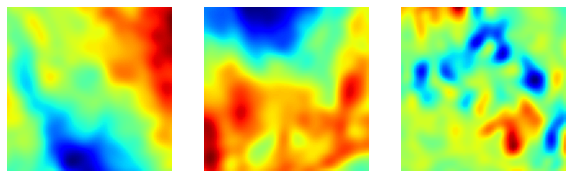

In [14]:
fig = show(inputs[:3])

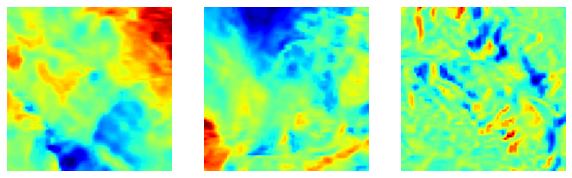

In [15]:
fig = show(outputs[:3])

Epoch 1/50


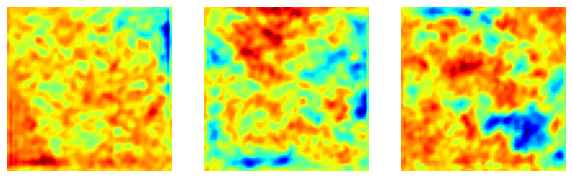

48/68 [====================>.........] - ETA: 47s - d_loss: -10.2023 - g_loss: 14.5703 - d_fake: 3.4248 - d_real: -0.8322 - g_root_mean_squared_error: 3.2077 - g_lsd: 10.2076 - g_extreme_rmse: 1.7932 - g_ws_weighted_rmse: 4.2917 - g_spatial_ks: 0.6405 - g_acd: 0.4804

In [ ]:
gan.fit(inputs, outputs, callbacks=callbacks, epochs=50, batch_size=BATCH_SIZE, validation_split=0.25)